# Access SMAP Data

In [1]:
from src.download_SPL3SMP import cmr_download, cmr_search
start_date = "2024-10-01"

lat = 24
lon = 28

In [56]:
import math 

def get_bounding_box(lat, lon, above_below_km, left_right_km):
    # Latitude and longitude change calculations
    lat_change = above_below_km / 111
    lon_change = left_right_km / (111 * math.cos(math.radians(lat)))
    
    # Bounding box coordinates
    min_lat = lat - lat_change #S
    max_lat = lat + lat_change #N
    min_lon = lon - lon_change #W
    max_lon = lon + lon_change #E
    
    return min_lon, min_lat, max_lon, max_lat

def get_bounding_box_str(lat, lon, above_below_km, left_right_km):
    min_lon, min_lat, max_lon, max_lat = get_bounding_box(lat, lon, above_below_km, left_right_km)
    return f"{min_lon},{min_lat},{max_lon},{max_lat}"

In [58]:

short_name = 'SPL3SMP'
version = '009'
time_start = '2024-10-01T00:00:00Z'
time_end = '2024-10-02T21:48:13Z'
bounding_box = get_bounding_box_str(lat, lon, 10, 10)
polygon = ''
filename_filter = ''
url_list = []

force = False
quiet = False

In [59]:
folder_path = "../datasets/smap"

In [63]:
try:
    url_list = cmr_search(short_name, version, time_start, time_end,
                          bounding_box=bounding_box, polygon=polygon,
                          filename_filter=filename_filter, quiet=quiet)

    cmr_download(url_list, force=force, quiet=quiet, folder_path=folder_path)


    
except KeyboardInterrupt:
    quit()

Querying for data:
	https://cmr.earthdata.nasa.gov/search/granules.json?&sort_key[]=start_date&sort_key[]=producer_granule_id&scroll=true&page_size=2000&short_name=SPL3SMP&version=009&version=09&version=9&temporal[]=2024-10-01T00:00:00Z,2024-10-02T21:48:13Z&bounding_box=27.90138411905351,23.90990990990991,28.09861588094649,24.09009009009009&provider=NSIDC_ECS

Found 1 matches.
1/2: SMAP_L3_SM_P_20241001_R19240_001.h5
  File exists, skipping
2/2: SMAP_L3_SM_P_20241001_R19240_001.h5.iso.xml
  File exists, skipping


In [64]:
file_name = url_list[0].split('/')[-1]
file_name

'SMAP_L3_SM_P_20241001_R19240_001.h5'

In [65]:
path = folder_path + "/" + file_name
path

'../datasets/smap/SMAP_L3_SM_P_20241001_R19240_001.h5'

In [66]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
from pyhdf.SD import SD, SDC
# from pyhdf.
import h5py 

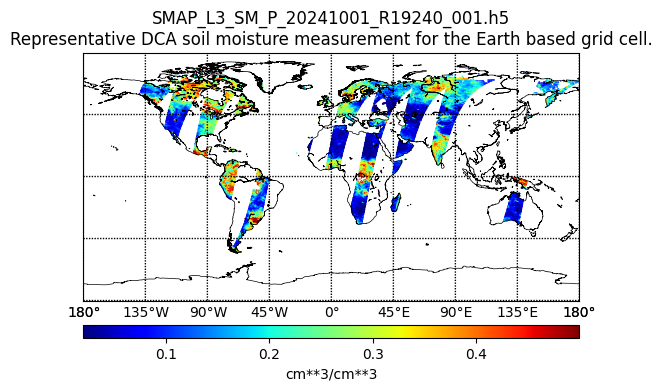

In [67]:
with h5py.File(path, mode="r") as f:
    name = '/Soil_Moisture_Retrieval_Data_AM/soil_moisture'
    data = f[name][:]
    units = f[name].attrs['units']
    units = units.decode('ascii', 'replace')
    long_name = f[name].attrs['long_name']
    long_name = long_name.decode('ascii', 'replace')
    _FillValue = f[name].attrs['_FillValue']
    valid_max = f[name].attrs['valid_max']
    valid_min = f[name].attrs['valid_min']        
    invalid = np.logical_or(data > valid_max,
                            data < valid_min)
    invalid = np.logical_or(invalid, data == _FillValue)
    data[invalid] = np.nan
    data = np.ma.masked_where(np.isnan(data), data)
        
    # Get the geolocation data
    latitude = f['/Soil_Moisture_Retrieval_Data_AM/latitude'][:]
    longitude = f['/Soil_Moisture_Retrieval_Data_AM/longitude'][:]

        
    m = Basemap(projection='cyl', resolution='l',
                llcrnrlat=-90, urcrnrlat=90,
                llcrnrlon=-180, urcrnrlon=180)
    m.drawcoastlines(linewidth=0.5)
    m.drawparallels(np.arange(-90, 91, 45))
    m.drawmeridians(np.arange(-180, 180, 45), labels=[True,False,False,True])
    m.scatter(longitude, latitude, c=data, s=1, cmap=plt.cm.jet,
            edgecolors=None, linewidth=0)
    cb = m.colorbar(location="bottom", pad='10%')    
    cb.set_label(units)

    basename = os.path.basename(file_name)
    plt.title('{0}\n{1}'.format(basename, long_name))
    fig = plt.gcf()
    plt.savefig(f"../assets/plots/{basename}.py.png")

In [106]:
def get_soil_moist_from_path(path, bounding_box, is_am = True):
    with h5py.File(path, mode="r") as f:
        field_time = 'AM' if is_am else "PM"
        name = f'/Soil_Moisture_Retrieval_Data_{field_time}/soil_moisture'

        data = f[name][:]
        _FillValue = f[name].attrs['_FillValue']
        valid_max = f[name].attrs['valid_max']
        valid_min = f[name].attrs['valid_min']        
        
        invalid = np.logical_or(data > valid_max,
                                data < valid_min)
        invalid = np.logical_or(invalid, data == _FillValue)
        
        data[invalid] = 0 # to ignore in getting average
        # get 
        latitude = f['/Soil_Moisture_Retrieval_Data_AM/latitude'][:]
        longitude = f['/Soil_Moisture_Retrieval_Data_AM/longitude'][:]
        min_lon, min_lat, max_lon, max_lat = bounding_box

        n, m = data.shape
        sum, cnt = 0, 0
        for i in range(n):
            for j in range(m):
                if (min_lon <= longitude[i][j] <= max_lon) and (min_lat <= latitude[i][j] <= max_lat) and (data[i][j] != 0):
                    sum += data[i][j]
                    cnt += 1
        return (sum / cnt)


In [110]:
def fetch_data(lat, lon, folder_path="../datasets/smap", time_start = '2024-10-01T00:00:00Z', time_end = '2024-10-02T21:48:13Z'):
    short_name = 'SPL3SMP'
    version = '009'
    polygon = ''
    filename_filter = ''
    url_list = []
    bounding_box = get_bounding_box_str(lat, lon, 10, 10)
    force = False
    quiet = False
    
    try:
        url_list = cmr_search(short_name, version, time_start, time_end,
                              bounding_box=bounding_box, polygon=polygon,
                              filename_filter=filename_filter, quiet=quiet)
        cmr_download(url_list, force=force, quiet=quiet, folder_path=folder_path)
    except KeyboardInterrupt: # to graceful shutdown when intrrput
        quit()

    return url_list

url_list = fetch_data(lat, lon)

folder_path = "../datasets/smap"
file_name = url_list[0].split('/')[-1]
path = folder_path + "/" + file_name
bounding_box = get_bounding_box(lat, lon, 70, 70)
answer = get_soil_moist_from_path(path, bounding_box)
    
print(answer)
    
    

0.03291768301278353
